In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
for d in latest_date:
    dates = d.split('-')

start_date = dt.date(int(dates[0]), int(dates[1]), int(dates[2]))
#print(f"Start Date - {start_date}")
# Calculate the date 1 year ago from the last data point in the database
twelve_months_ago = query_date = start_date - dt.timedelta(days=365)
#print(f"End Date - {twelve_months_ago}")

# Perform a query to retrieve the data and precipitation scores
data = session.query(Measurement).filter(Measurement.date <= start_date).\
    filter(Measurement.date >= twelve_months_ago).order_by(Measurement.date.desc()).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame([(d.prcp, d.date) for d in data], 
                  columns=['Precipitation', 'Date'])
# Sort the dataframe by date (#data is sorted by date)

prcp_clean_df = prcp_df.dropna(how='any')
prcp_nonzero_df = prcp_clean_df.loc[prcp_clean_df['Precipitation'] != 0.0]

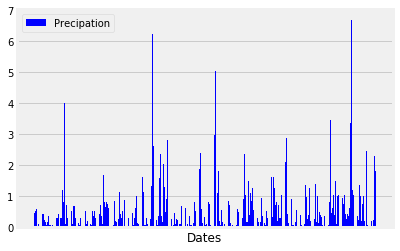

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data
w_type=['Precipation']
plt.bar(prcp_nonzero_df['Date'], prcp_nonzero_df['Precipitation'], color='b')
plt.legend(w_type, loc='best')
plt.xticks([])
plt.xlabel("Dates")
plt.grid(zorder=0)

# Get current size
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 25
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data

In [14]:
prcp_nonzero_df.describe()

,Precipitation
count,1147.000000
mean,0.312363
std,0.576781
min,0.010000
25%,0.030000
50%,0.100000
75%,0.310000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement).distinct(Measurement.station).group_by(Measurement.station).count()

9

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station).label("count")).group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
print(active_stations)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
params = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
session.query(*params).filter(Measurement.station == active_stations[0][0]).all()

[(54.0, 85.0, 71.66378066378067)]

In [18]:
# Choose the station with the highest number of temperature observations.
station_with_highest_temp = session.query(Measurement.station, Measurement.tobs).order_by(Measurement.tobs.desc()).first()
print(f"Station with max temprature - {station_with_highest_temp[0]}")

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data_by_station = session.query(Measurement).\
    filter(Measurement.station == station_with_highest_temp[0]).filter(Measurement.date <= start_date).\
    filter(Measurement.date >= twelve_months_ago).order_by(Measurement.tobs).all()
#print(temp_data_by_station)
# create dataframe
temp_df = pd.DataFrame([(d.tobs) for d in temp_data_by_station], 
                  columns=['Temp'])
temp_df.head()

Station with max temprature - USC00519397


,Temp
0,60.0
1,61.0
2,61.0
3,62.0
4,62.0


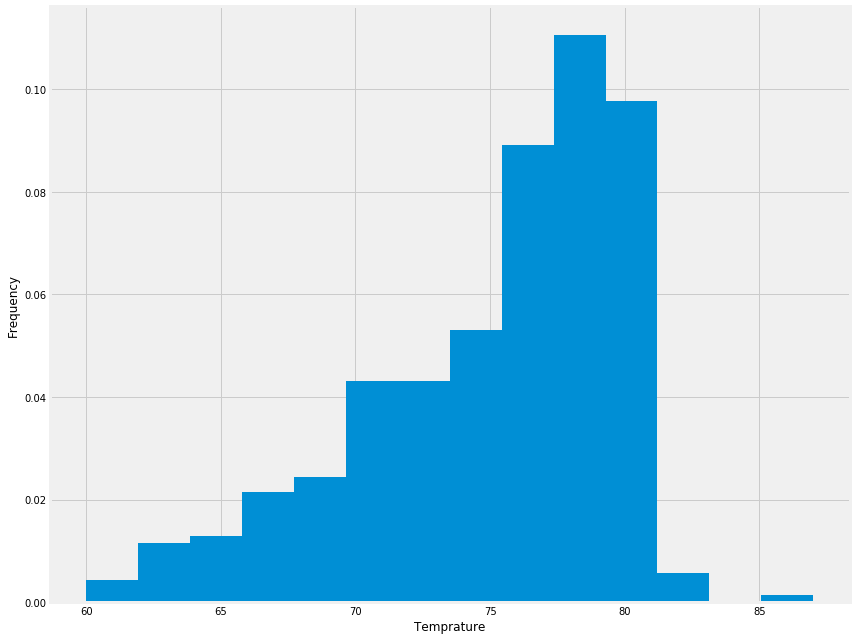

In [20]:
#plot histogram
fig, ax = plt.subplots()
n, bins, patches = ax.hist(temp_df['Temp'], bins='auto', density=1)
ax.set_xlabel('Temprature')
ax.set_ylabel('Frequency')
#ax.set_title(r'Histogram for station')
# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()

![precipitation](Images/station-histogram.png)

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
begin_date = '2017-05-28'
end_date = '2017-06-05'
calculated_temps = calc_temps(begin_date, end_date)
print(calculated_temps)

[(71.0, 77.28301886792453, 82.0)]


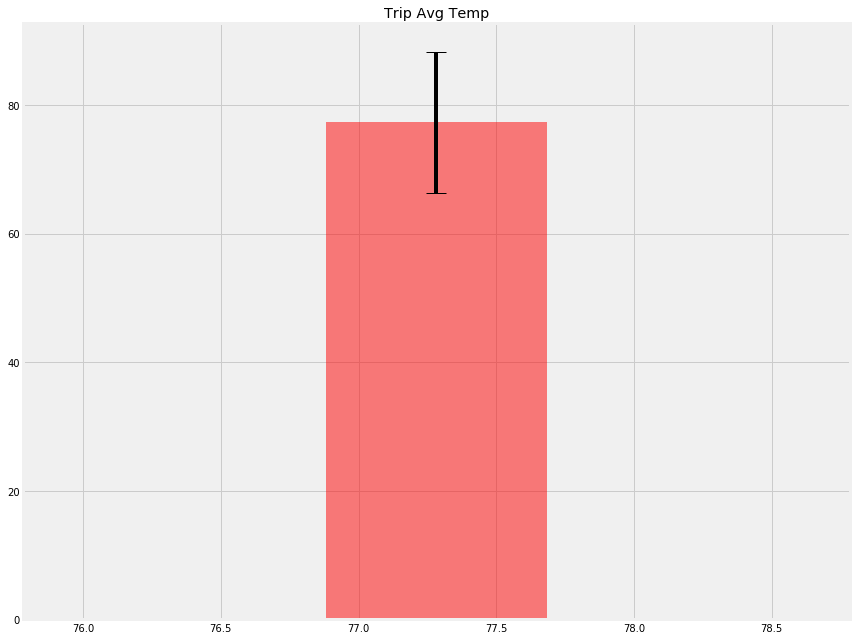

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots()
n = ax.bar(calculated_temps[0][1], 
             calculated_temps[0][1], 
             yerr=(calculated_temps[0][2]-calculated_temps[0][0]),
             align='center', ecolor='black', capsize=10,
             color="r", 
             alpha=0.5)
ax.set_xlim(calculated_temps[0][1] - 1.5, calculated_temps[0][1] + 1.5)
ax.set_title("Trip Avg Temp")
fig.tight_layout()
plt.show()

In [25]:
# Get a list of column names and types
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [26]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [27]:
session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, Measurement.prcp).\
    filter(Measurement.station == Station.station).filter(Measurement.date >= begin_date).\
    filter(Measurement.date <= end_date).order_by(Measurement.prcp.desc()).all()

[('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  1.12),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.82),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.4),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.29),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.26),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.25),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.2),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.2),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.16),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.15),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.15),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',


## Optional Challenge Assignment

In [28]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    #print(f"{date} type {type(date)}")
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [29]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [30]:
import datetime
my_trip_dates = pd.date_range(begin_date, end_date).tolist()
#print(my_trip_dates)
normal_values = []
for d in my_trip_dates:
    formatted_date = datetime.datetime.strftime(d, '%m-%d')
    #print(formatted_date)
    values = daily_normals(formatted_date)
    normal_values.append(values)

print(normal_values)

[[(67.0, 74.27777777777777, 82.0)], [(64.0, 74.19607843137256, 80.0)], [(69.0, 74.33333333333333, 81.0)], [(68.0, 74.4, 81.0)], [(64.0, 74.6140350877193, 81.0)], [(65.0, 74.4, 81.0)], [(65.0, 74.03448275862068, 80.0)], [(65.0, 73.81818181818181, 81.0)], [(68.0, 74.85454545454546, 81.0)]]


In [31]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
modified_list = {}
min_values = []
avg_values = []
max_values = []
for data in normal_values:
    min_values.append(data[0][0])
    avg_values.append(data[0][1])
    max_values.append(data[0][2])

modified_list = {"Min" : min_values,
                "Avg" : avg_values,
                "Max" : max_values,
                "Date" : my_trip_dates
                }
normalized_df = pd.DataFrame(modified_list)
normalized_df = normalized_df.set_index('Date')
normalized_df.head()

,Min,Avg,Max
Date,,,
2017-05-28,67.0,74.277778,82.0
2017-05-29,64.0,74.196078,80.0
2017-05-30,69.0,74.333333,81.0
2017-05-31,68.0,74.400000,81.0
2017-06-01,64.0,74.614035,81.0


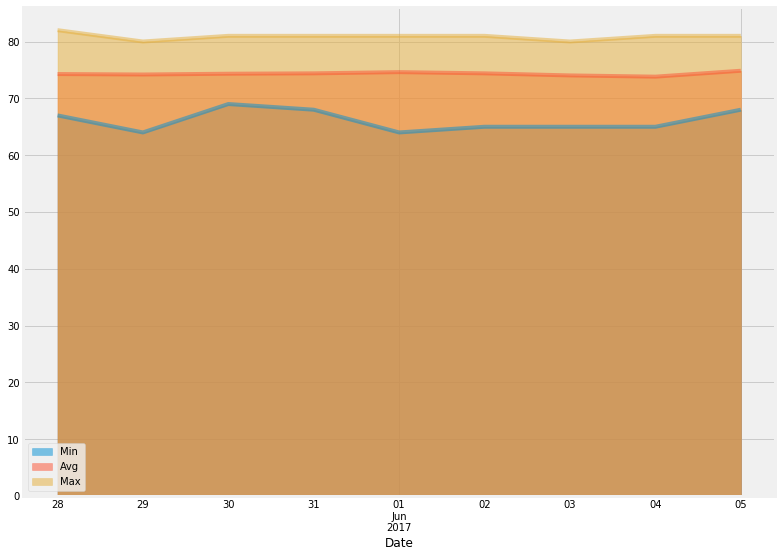

In [32]:
# Plot the daily normals as an area plot with `stacked=False`
#import pandas
normalized_df.plot(kind='area', stacked=False, alpha=0.5)
plt.show()
